In [21]:
"""
3D-FRONT Scene Isometric Visualizer for Jupyter Notebook
Visualize scenes with textured and semantic views side-by-side
"""

import json
import sys
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Add parent directory to path to import utils
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from data_preperation.utils.semantic_utils import Taxonomy


# =============================================================================
# Configuration
# =============================================================================

class VisualizationConfig:
    """Configuration for scene visualization"""
    def __init__(self):
        self.max_points = 50000
        self.point_size = 1.0
        self.figsize = (16, 8)
        self.dpi = 150
        self.elev = 30
        self.azim = 225
        self.format = "parquet"
        
    def update(self, **kwargs):
        """Update configuration with keyword arguments"""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
        return self


# =============================================================================
# Core Functions
# =============================================================================

def load_point_cloud(scene_dir: Path, scene_id: str, format: str = "parquet") -> pd.DataFrame:
    """Load point cloud from parquet or csv."""
    if format == "parquet":
        file_path = scene_dir / f"{scene_id}_sem_pointcloud.parquet"
        return pd.read_parquet(file_path)
    else:
        file_path = scene_dir / f"{scene_id}_sem_pointcloud.csv"
        return pd.read_csv(file_path)


def load_scene_info(scene_dir: Path, scene_id: str) -> Dict:
    """Load scene metadata."""
    scene_info_path = scene_dir / f"{scene_id}_scene_info.json"
    with open(scene_info_path, 'r') as f:
        return json.load(f)


def create_category_colormap(taxonomy: Taxonomy, categories: List[str]) -> Dict[str, np.ndarray]:
    """Create a consistent color mapping for categories using taxonomy colors."""
    unique_cats = sorted(set(categories))
    
    color_map = {}
    for cat in unique_cats:
        # Try to get color from taxonomy
        try:
            # Get the category ID first
            cat_id = taxonomy.translate(cat, output="id")
            if cat_id is not None:
                # Get color from taxonomy (assumes it returns RGB tuple or hex)
                tax_color = taxonomy.get_color(cat_id)
                if tax_color is not None:
                    # Convert to numpy array if needed
                    if isinstance(tax_color, str):
                        # Hex color
                        tax_color = tax_color.lstrip('#')
                        color_map[cat] = np.array([int(tax_color[i:i+2], 16) for i in (0, 2, 4)]) / 255.0
                    else:
                        # Assume RGB tuple (0-255 or 0-1)
                        rgb = np.array(tax_color)
                        if rgb.max() > 1.0:
                            rgb = rgb / 255.0
                        color_map[cat] = rgb[:3]  # RGB only, no alpha
                    continue
        except (AttributeError, KeyError, TypeError):
            pass
        
        # Fallback: use colormap for categories not in taxonomy
        idx = list(unique_cats).index(cat)
        base_colors = plt.cm.tab20c(np.linspace(0, 1, 20))
        extended_colors = plt.cm.Set3(np.linspace(0, 1, 12))
        all_colors = np.vstack([base_colors, extended_colors])
        color_map[cat] = all_colors[idx % len(all_colors)][:3]
    
    # Override for architectural elements if not in taxonomy
    if 'floor' in color_map and 'floor' not in [c for c in unique_cats if taxonomy.translate(c, output="id") is not None]:
        color_map['floor'] = np.array([0.8, 0.8, 0.8])
    if 'wall' in color_map and 'wall' not in [c for c in unique_cats if taxonomy.translate(c, output="id") is not None]:
        color_map['wall'] = np.array([0.9, 0.9, 0.85])
    
    return color_map


def downsample_points(df: pd.DataFrame, max_points: int) -> pd.DataFrame:
    """Downsample point cloud for faster rendering."""
    if len(df) <= max_points:
        return df
    
    indices = np.random.choice(len(df), max_points, replace=False)
    return df.iloc[indices]


def setup_isometric_view(ax: Axes3D, bounds: Dict, elev: float = 30, azim: float = 225):
    """Configure axis for isometric view."""
    # Swap Y and Z bounds since we're plotting (X, Z, Y)
    x_range = bounds['max'][0] - bounds['min'][0]
    y_range = bounds['max'][2] - bounds['min'][2]  # Z becomes vertical
    z_range = bounds['max'][1] - bounds['min'][1]  # Y becomes depth
    
    max_range = max(x_range, y_range, z_range)
    mid_x = (bounds['max'][0] + bounds['min'][0]) / 2
    mid_y = (bounds['max'][2] + bounds['min'][2]) / 2  # Z
    mid_z = (bounds['max'][1] + bounds['min'][1]) / 2  # Y
    
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)
    
    # Isometric viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Clean up axes - now Z from data is Y axis in plot (vertical)
    ax.set_xlabel('X')
    ax.set_ylabel('Z (Up)')
    ax.set_zlabel('Y')
    ax.grid(True, alpha=0.3)


def plot_textured_view(ax: Axes3D, df: pd.DataFrame, bounds: Dict, 
                       point_size: float = 1.0, elev: float = 30, azim: float = 225):
    """Plot textured (RGB) view."""
    # Normalize RGB values
    colors = np.column_stack([df['r'], df['g'], df['b']]) / 255.0
    
    # Swap Y and Z to make Z vertical (up direction)
    ax.scatter(df['x'], df['z'], df['y'], 
               c=colors, 
               s=point_size, 
               alpha=0.8,
               edgecolors='none')
    
    setup_isometric_view(ax, bounds, elev, azim)
    ax.set_title('Textured View', fontsize=14, fontweight='bold')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])


def plot_semantic_view(ax: Axes3D, df: pd.DataFrame, bounds: Dict, 
                       taxonomy: Taxonomy, point_size: float = 1.0, 
                       elev: float = 30, azim: float = 225, show_legend: bool = True):
    """Plot semantic (category-colored) view."""
    # Create color mapping
    color_map = create_category_colormap(taxonomy, df['category'].tolist())
    
    # Assign colors to each point
    colors = np.array([color_map[cat] for cat in df['category']])
    
    # Swap Y and Z to make Z vertical (up direction)
    ax.scatter(df['x'], df['z'], df['y'], 
               c=colors, 
               s=point_size, 
               alpha=0.8,
               edgecolors='none')
    
    setup_isometric_view(ax, bounds, elev, azim)
    ax.set_title('Semantic View', fontsize=14, fontweight='bold')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Add legend for top categories
    if show_legend:
        unique_cats = df['category'].value_counts().head(10).index.tolist()
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                       markerfacecolor=color_map[cat], 
                                       markersize=8, label=cat)
                           for cat in unique_cats if cat in color_map]
        
        ax.legend(handles=legend_elements, loc='upper left', 
                  bbox_to_anchor=(1.05, 1), fontsize=8)


# =============================================================================
# Main Visualization Function
# =============================================================================

def visualize_scene(scene_dir: Path, 
                   scene_id: str, 
                   taxonomy: Taxonomy,
                   config: Optional[VisualizationConfig] = None,
                   output_path: Optional[Path] = None,
                   show_legend: bool = True) -> plt.Figure:
    """
    Create side-by-side isometric visualization.
    
    Parameters
    ----------
    scene_dir : Path
        Directory containing scene point clouds and metadata
    scene_id : str
        Scene ID to visualize
    taxonomy : Taxonomy
        Taxonomy object for semantic mapping
    config : VisualizationConfig, optional
        Configuration object with visualization parameters
    output_path : Path, optional
        If provided, save figure to this path
    show_legend : bool, default=True
        Whether to show the category legend
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure
    """
    if config is None:
        config = VisualizationConfig()
    
    # Load data
    print(f"Loading scene {scene_id}...")
    df = load_point_cloud(scene_dir, scene_id, config.format)
    scene_info = load_scene_info(scene_dir, scene_id)
    
    # Downsample if needed
    if len(df) > config.max_points:
        print(f"Downsampling from {len(df)} to {config.max_points} points...")
        df = downsample_points(df, config.max_points)
    
    # Create figure with two subplots
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    
    # Textured view (left)
    ax1 = fig.add_subplot(121, projection='3d')
    plot_textured_view(ax1, df, scene_info['bounds'], 
                      config.point_size, config.elev, config.azim)
    
    # Semantic view (right)
    ax2 = fig.add_subplot(122, projection='3d')
    plot_semantic_view(ax2, df, scene_info['bounds'], taxonomy, 
                      config.point_size, config.elev, config.azim, show_legend)
    
    # Add main title
    fig.suptitle(f'Scene: {scene_id}', fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        output_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(output_path, bbox_inches='tight', dpi=config.dpi)
        print(f"Saved visualization to {output_path}")
    
    return fig


# =============================================================================
# Convenience Functions
# =============================================================================

def quick_viz(scene_dir: str, scene_id: str, taxonomy_path: str, **kwargs):
    """Quick visualization with string paths."""
    taxonomy = Taxonomy(Path(taxonomy_path))
    config = VisualizationConfig()
    config.update(**kwargs)
    
    return visualize_scene(
        Path(scene_dir), 
        scene_id, 
        taxonomy, 
        config
    )


def batch_visualize(scene_dir: Path, 
                   scene_ids: List[str], 
                   taxonomy: Taxonomy,
                   output_dir: Optional[Path] = None,
                   config: Optional[VisualizationConfig] = None):
    """Visualize multiple scenes."""
    if config is None:
        config = VisualizationConfig()
    
    if output_dir:
        output_dir.mkdir(parents=True, exist_ok=True)
    
    for scene_id in scene_ids:
        print(f"\n{'='*60}")
        print(f"Processing: {scene_id}")
        print('='*60)
        
        try:
            output_path = output_dir / f"{scene_id}_viz.png" if output_dir else None
            fig = visualize_scene(scene_dir, scene_id, taxonomy, config, output_path)
            
            if not output_path:
                plt.show()
            plt.close(fig)
            
        except Exception as e:
            print(f"Error processing {scene_id}: {e}")


def print_scene_stats(scene_dir: Path, scene_id: str, format: str = "parquet"):
    """Print statistics about a scene."""
    df = load_point_cloud(scene_dir, scene_id, format)
    
    print(f"Scene: {scene_id}")
    print(f"Total points: {len(df):,}")
    print(f"\nTop 15 Categories:")
    print(df['category'].value_counts().head(15))
    print(f"\nRoom types:")
    print(df['room_type'].value_counts())
    print(f"\nBounds:")
    print(f"  X: [{df['x'].min():.2f}, {df['x'].max():.2f}]")
    print(f"  Y: [{df['y'].min():.2f}, {df['y'].max():.2f}]")
    print(f"  Z: [{df['z'].min():.2f}, {df['z'].max():.2f}]")
    
    return df


print("✓ Visualization functions loaded successfully!")
print("\nQuick start examples:")
print("  1. print_scene_stats(scene_dir, scene_id)")
print("  2. config = VisualizationConfig()")
print("  3. fig = visualize_scene(scene_dir, scene_id, taxonomy, config)")

✓ Visualization functions loaded successfully!

Quick start examples:
  1. print_scene_stats(scene_dir, scene_id)
  2. config = VisualizationConfig()
  3. fig = visualize_scene(scene_dir, scene_id, taxonomy, config)


In [22]:

scene_dir = Path(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\dataset\00ecd5d3-d369-459f-8300-38fc159823dc")
scene_id = "00ecd5d3-d369-459f-8300-38fc159823dc"
taxonomy_path = Path(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\config\taxonomy.json")

taxonomy = Taxonomy(taxonomy_path)


In [ ]:

# Cell 2: Quick stats
print_scene_stats(scene_dir, scene_id)


Scene: 00ecd5d3-d369-459f-8300-38fc159823dc
Total points: 502,808

Categories:
category
wall                                             314625
floor                                             48868
Wardrobe                                          27566
King-size Bed                                     22027
L-shaped Sofa                                     21384
Children Cabinet                                  20936
unknown                                           10604
TV Stand                                           7353
Nightstand                                         5368
Sideboard / Side Cabinet / Console Table           4050
Pendant Lamp                                       3831
Dining Table                                       3299
Dining Chair                                       3084
armchair                                           2685
Footstool / Sofastool / Bed End Stool / Stool      2662
Name: count, dtype: int64

Room types:
room_type
LivingDiningRoom    236

Loading scene 00ecd5d3-d369-459f-8300-38fc159823dc...
Downsampling from 502808 to 50000 points...


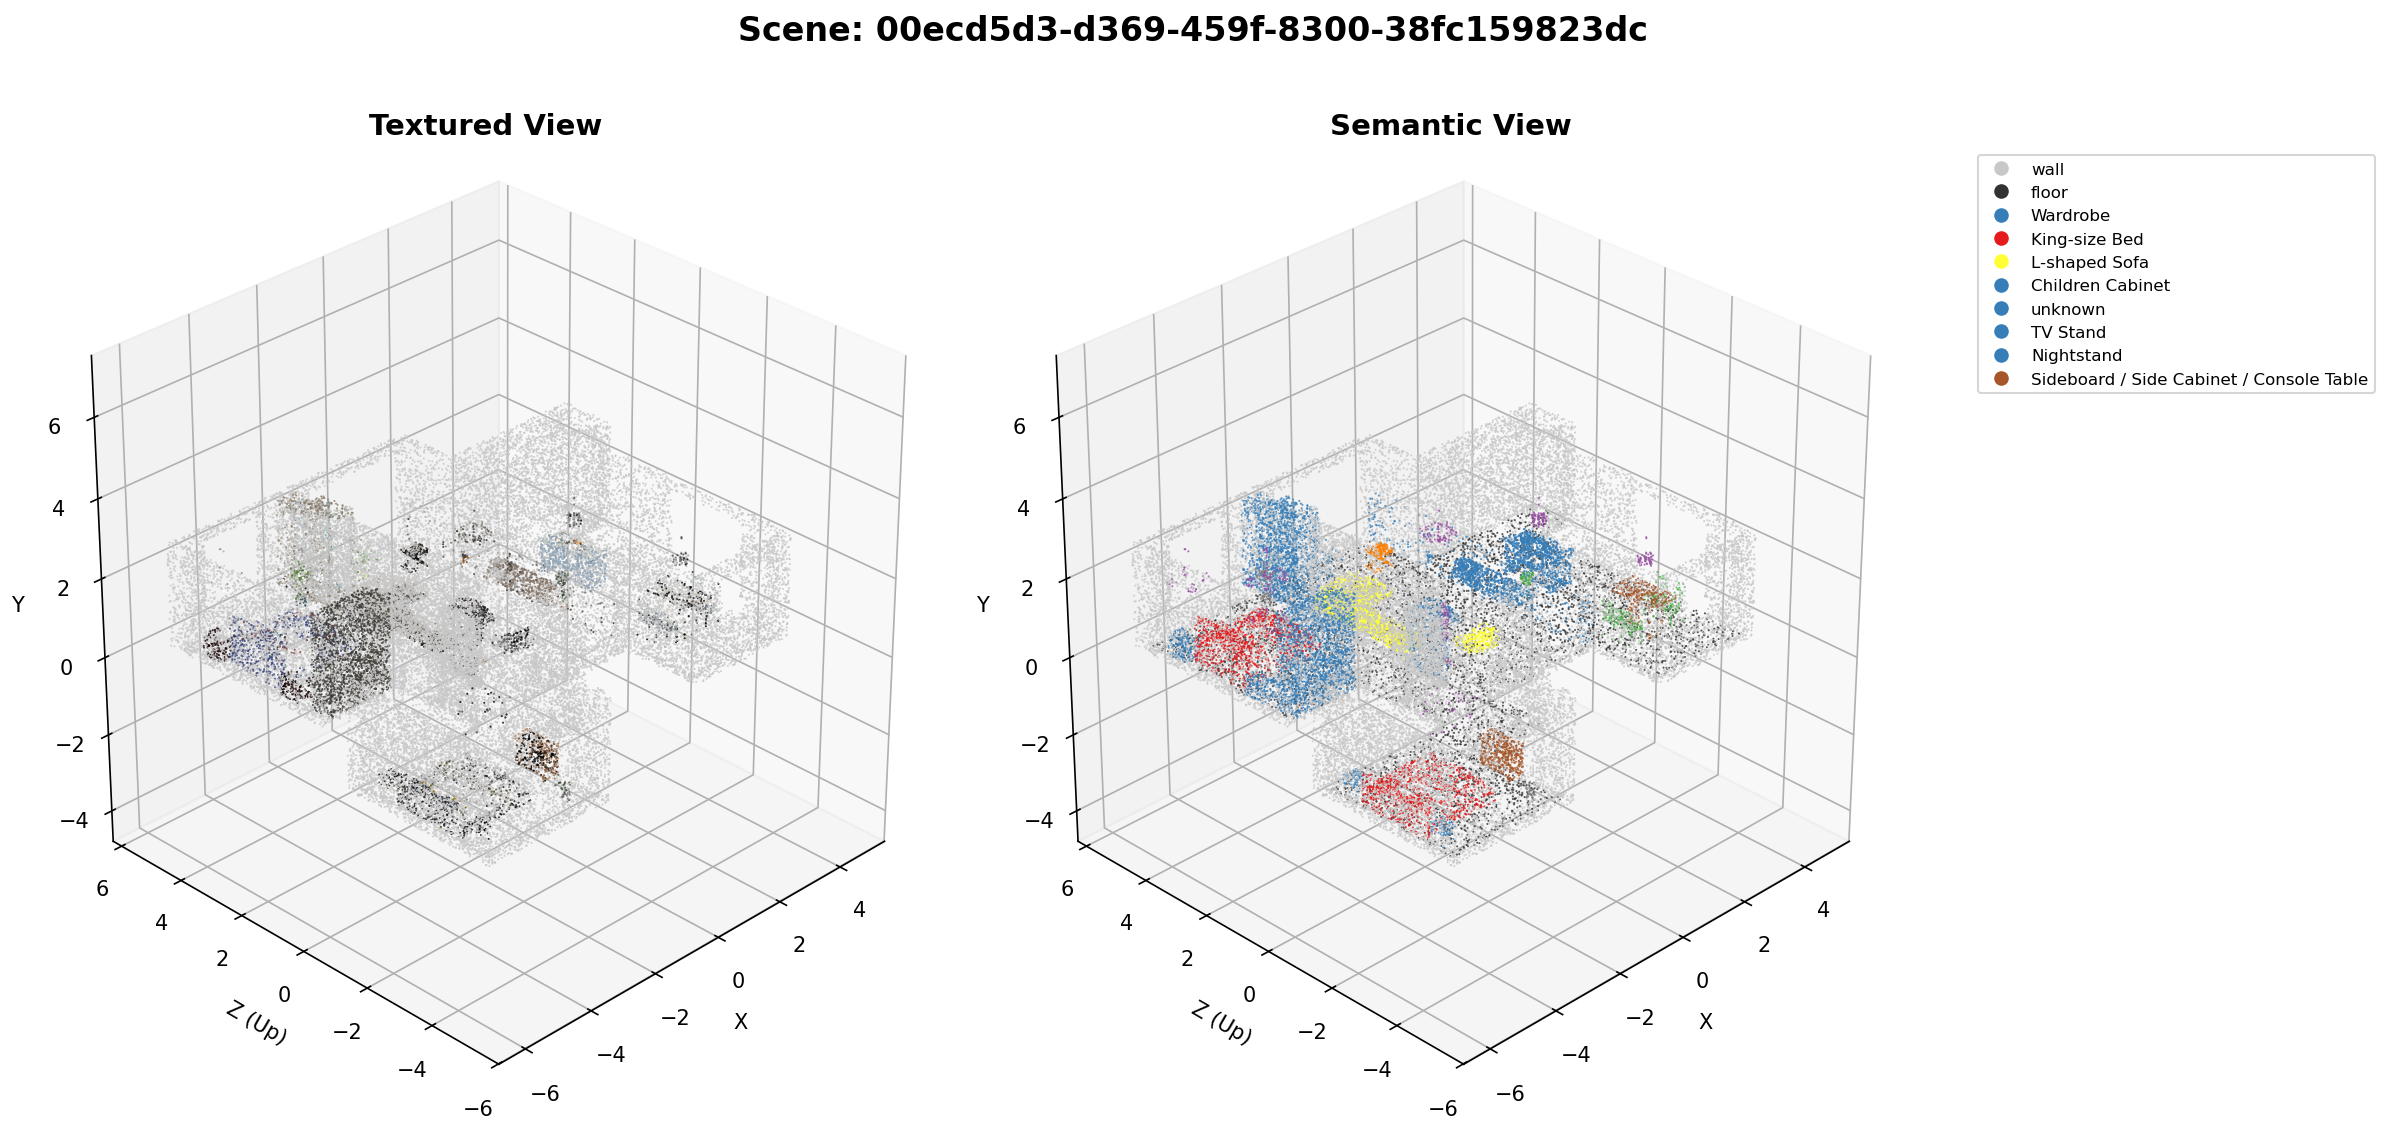

In [23]:

# Cell 3: Default visualization
config = VisualizationConfig()
fig = visualize_scene(scene_dir, scene_id, taxonomy, config)
plt.show()


Loading scene 00ecd5d3-d369-459f-8300-38fc159823dc...
Downsampling from 502808 to 100000 points...


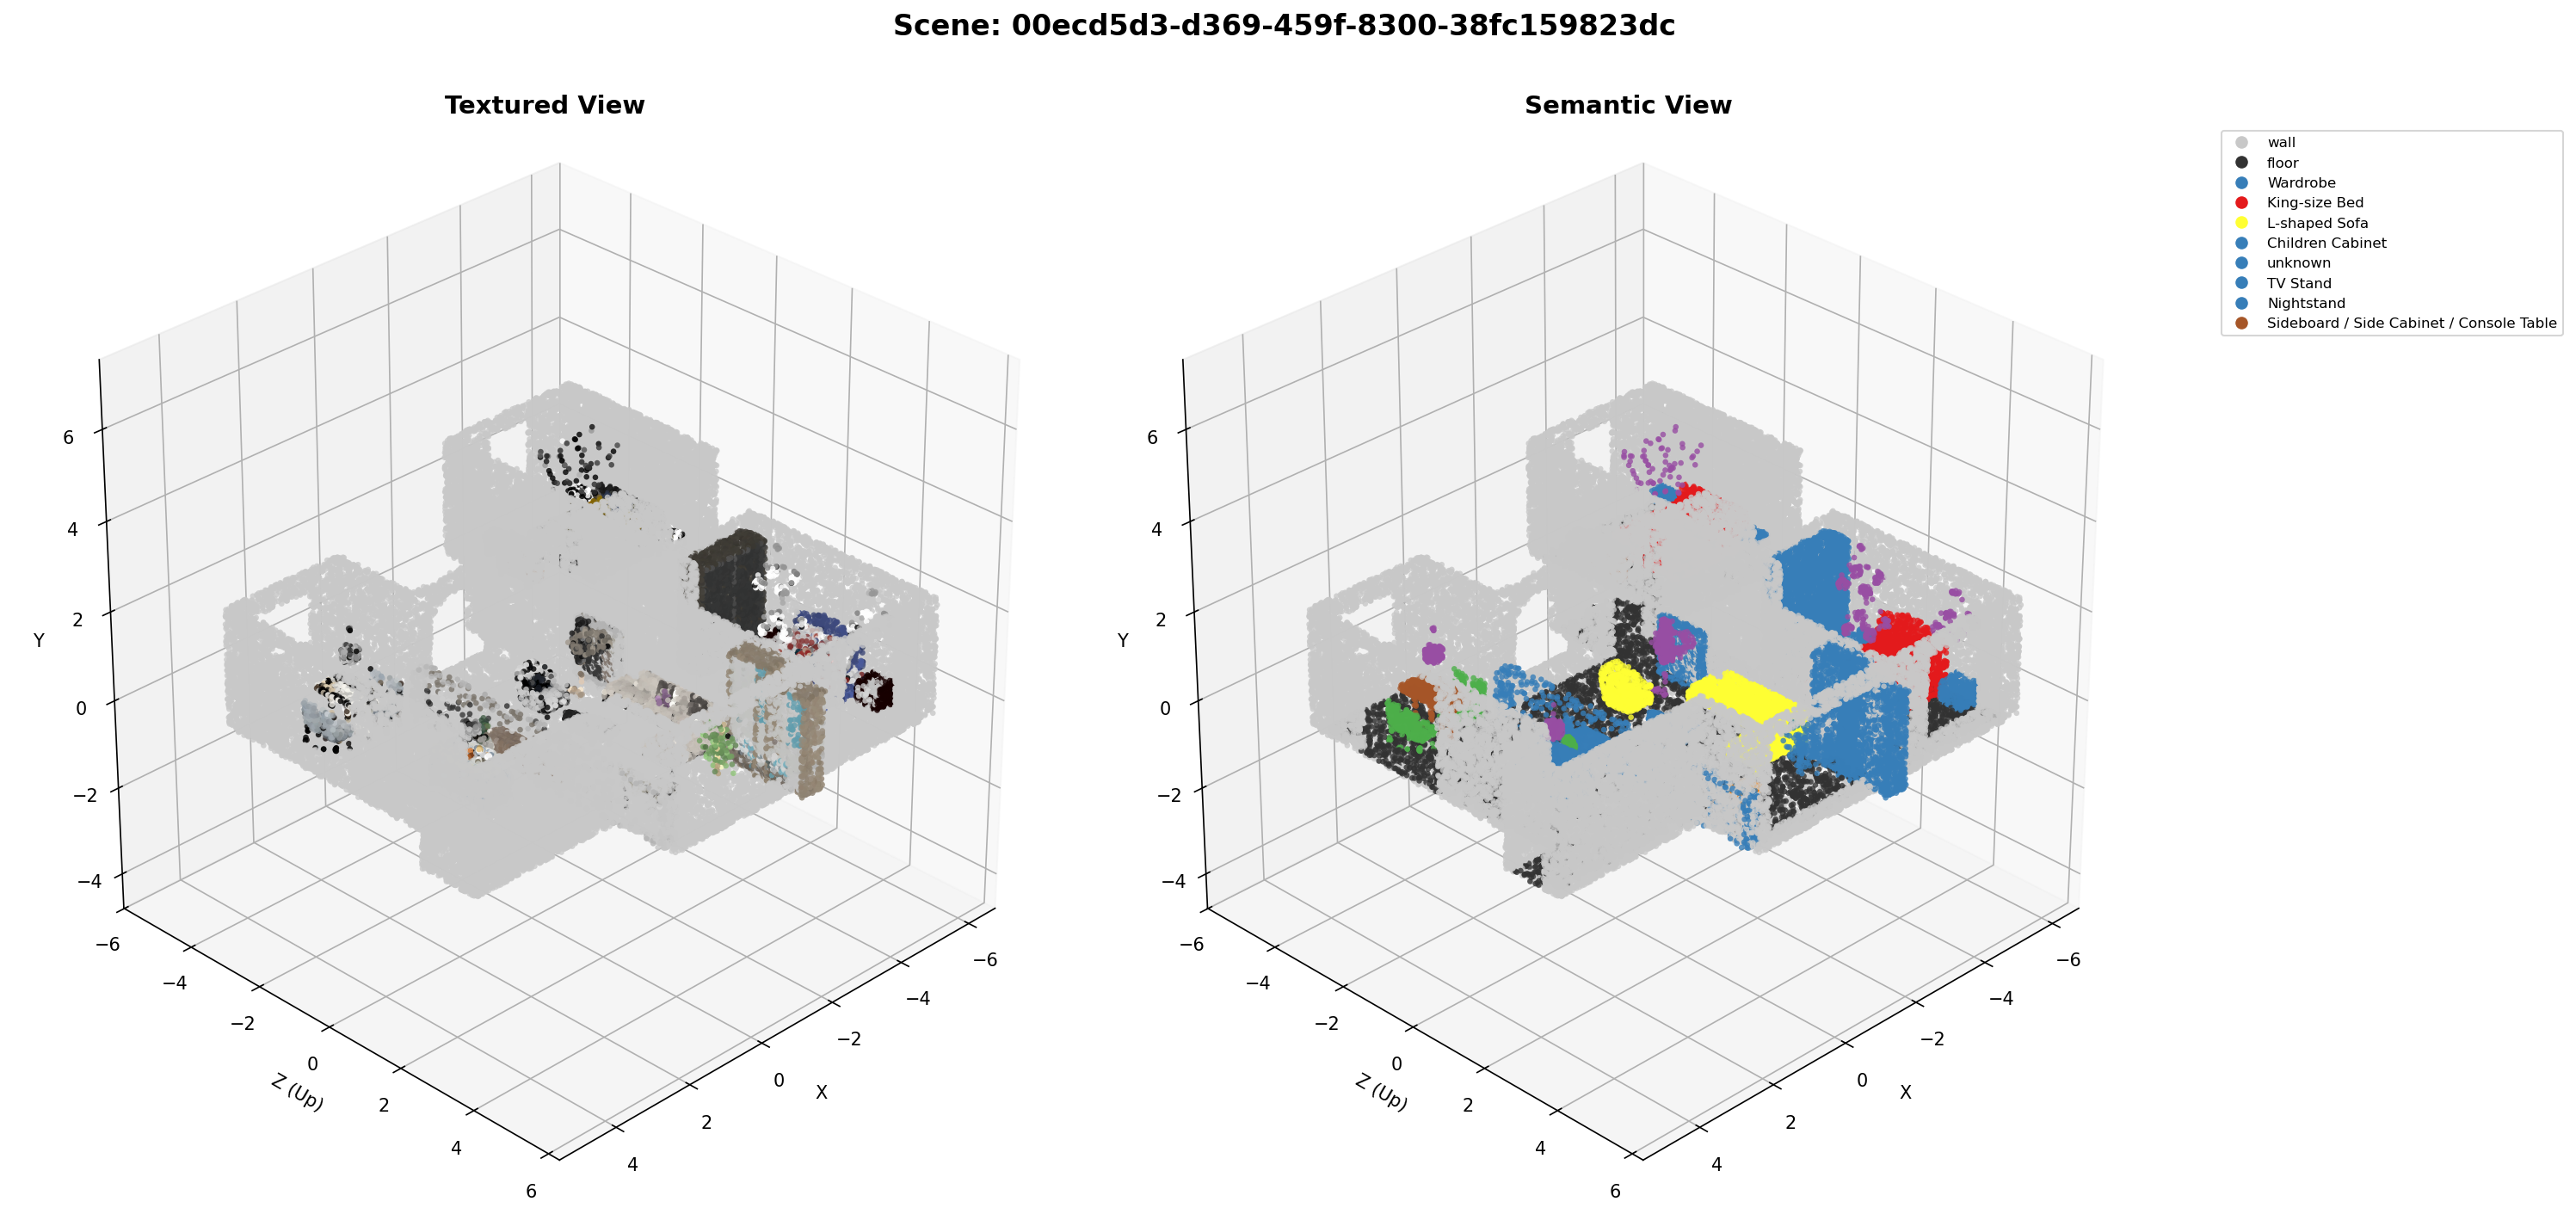

In [ ]:

# Cell 4: Custom view
config = VisualizationConfig()
config.update(
    elev=0,
    azim=60,
    max_points=100000,
    point_size=10,
    figsize=(20, 10)
)
fig = visualize_scene(scene_dir, scene_id, taxonomy, config)
plt.show()


In [ ]:

# Cell 5: Save high-quality output
config = VisualizationConfig()
config.update(max_points=100000, point_size=0.3, dpi=300, figsize=(20, 10))
output_path = Path("scene_viz_hq.png")
fig = visualize_scene(scene_dir, scene_id, taxonomy, config, output_path)


In [ ]:

# Cell 6: Quick visualization (one-liner)
fig = quick_viz(
    scene_dir=r"C:\path\to\scene",
    scene_id="00ad8345-45e0-45b3-867d-4a3c88c2517a",
    taxonomy_path=r"C:\path\to\taxonomy.json",
    elev=30,
    azim=225,
    max_points=50000
)


In [ ]:

# Cell 7: Batch process multiple scenes
scene_ids = ["scene1", "scene2", "scene3"]
output_dir = Path("visualizations")
config = VisualizationConfig()
config.update(max_points=50000, dpi=200)
batch_visualize(scene_dir, scene_ids, taxonomy, output_dir, config)
